In [1]:
from gneiss.composition import ilr_transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc

from biom import load_table
from skbio import TreeNode
%matplotlib inline

In [5]:
metadata = pd.read_table('../data/mapping_meta_urban_rural.txt', index_col=0)
table = load_table('../data/meta_urban_rural.biom')

ids = table.ids(axis='observation')
taxa = [table.metadata(id=i, axis='observation')['taxonomy'] for i in ids]
taxa = pd.DataFrame(taxa, index=ids, 
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'])

#tree = TreeNode.read('meta_ag4.27.17_qs850_qs10052_qs1448_100nt_placement.tog.tre')
tree = TreeNode.read('../data/meta_urban_rural_phylogeny.nwk')

In [6]:
otu_filter = lambda val, id_, md: val.sum() > 10
sparse_filter = lambda val, id_, md: (val>0).sum() > 10
table.filter(otu_filter, axis='observation')
table.filter(sparse_filter, axis='observation')

5530 x 14723 <class 'biom.table.Table'> with 1372334 nonzero entries (1% dense)

In [7]:
metadata = metadata.drop_duplicates()

In [8]:
table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                     columns=table.ids(axis='observation'),
                     index=table.ids(axis='sample'))

In [9]:
from gneiss.util import match, match_tips
table, metadata = match(table, metadata)
table, tree = match_tips(table, tree)

In [10]:
from gneiss.util import rename_internal_nodes
tree = rename_internal_nodes(tree)

In [11]:
from gneiss.composition import ilr_transform
from gneiss.regression import ols
from scipy.stats import dirichlet
from statsmodels.sandbox.stats.multicomp import multipletests

In [12]:
seed = np.random.RandomState(0)
alpha = np.ones(table.shape)
T = 50
models = []
for i in range(T):
    draw = np.zeros(table.shape)
    draw = np.vstack([dirichlet.rvs(table.values[j, :] + alpha[j, :], random_state=seed) 
                      for j in range(table.shape[0])])
    draw = pd.DataFrame(draw, table.index, table.columns)
    res = ols(r"country + C(life_style_2, Treatment('urban'))", ilr_transform(draw, tree), metadata)
    res.fit()
    models.append(res)

In [13]:
urban_pvals = pd.DataFrame({
    'rep%d'%i: r.pvalues.loc["C(life_style_2, Treatment('urban'))[T.remote_farmer]"] 
    for i, r in enumerate(models)})

med_urban_pvals = urban_pvals.apply(np.median, axis=1)
sig_urban_pvals = med_urban_pvals.loc[multipletests(med_urban_pvals, method='fdr_bh')[0]]

hunter_pvals = pd.DataFrame({
    'rep%d'%i: r.pvalues.loc["C(life_style_2, Treatment('urban'))[T.hunter-gatherer]"]    
    for i, r in enumerate(models)})

med_hunter_pvals = hunter_pvals.apply(np.median, axis=1)
sig_hunter_pvals = med_urban_pvals.loc[multipletests(med_hunter_pvals, method='fdr_bh')[0]]

In [14]:
balances = ilr_transform(table+1, tree)

In [19]:
sig_urban_pvals.head()

y46     1.588062e-08
y118    2.911339e-09
y156    3.019561e-06
y196    2.712179e-13
y222    1.208591e-08
dtype: float64

In [20]:
sig_hunter_pvals.head()

y41     2.874076e-01
y46     1.588062e-08
y118    2.911339e-09
y166    8.440062e-03
y196    2.712179e-13
dtype: float64

In [21]:
from gneiss.util import NUMERATOR, DENOMINATOR

balance_summary = pd.concat((taxa.loc[tree.find('y46').children[NUMERATOR].subset()],
                             taxa.loc[tree.find('y46').children[DENOMINATOR].subset()],
                             taxa.loc[tree.find('y463').children[NUMERATOR].subset()],
                             taxa.loc[tree.find('y463').children[DENOMINATOR].subset()]))

In [22]:
def balance_name(x):
    if x in tree.find('y46').subset():
        return 'y46'
    else:
        return 'y436'

def position(x):
    if (x in tree.find('y46').children[NUMERATOR].subset() or
        x in tree.find('y463').children[NUMERATOR].subset()
       ):
        return 'numerator'
    else:
        return 'denominator'

balance_summary['balance'] = list(map(balance_name, balance_summary.index))
balance_summary['position'] = list(map(position, balance_summary.index))

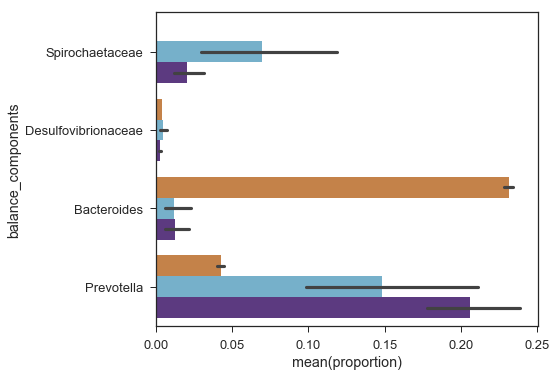

In [24]:
ctable = table.apply(lambda x: x / x.sum(), axis=1)
log_counts = pd.DataFrame({
'Spirochaetaceae': np.log(ctable[list(tree.find('y46').children[NUMERATOR].subset())]+1).sum(axis=1),
'Desulfovibrionaceae': np.log(ctable[list(tree.find('y46').children[DENOMINATOR].subset())]+1).sum(axis=1),
'Bacteroides': np.log(ctable[list(tree.find('y463').children[NUMERATOR].subset())]+1).sum(axis=1),
'Prevotella': np.log(ctable[list(tree.find('y463').children[DENOMINATOR].subset())]+1).sum(axis=1)
})

data = pd.merge(log_counts, metadata, left_index=True, right_index=True)
varz = list(log_counts.columns) + ['life_style_2']

df = pd.melt(data[varz], id_vars=['life_style_2'], var_name='balance_components', value_name='proportion')
#sns.factorplot(hue='life_style_2', y='balance', x='magnitude', data=df, kind='violin', size=4, aspect=2)
ax = sns.barplot(hue='life_style_2', y='balance_components', x='proportion', data=df, 
                   hue_order=['urban', 'hunter-gatherer', 'remote_farmer'],
                   order=['Spirochaetaceae', 'Desulfovibrionaceae', 'Bacteroides', 'Prevotella'],
                   palette={'urban':'#d98134',
                            'remote_farmer':'#5b2e8c',
                            'hunter-gatherer':'#68b6d8'})
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('rural_vs_urban_proportion_barplots.pdf')

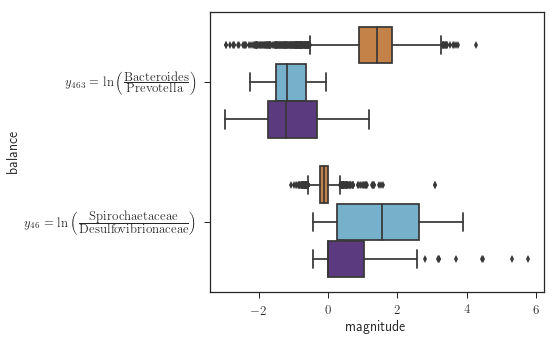

In [26]:
import seaborn as sns
rc('text', usetex=True)

sns.set(font_scale=1.3) 

sns.set_style('white')
sns.set_style('ticks')
plt.figure(figsize=(8, 5))
varz = ['y463', 'y46', 'life_style_2']
data = pd.merge(balances, metadata, left_index=True, right_index=True)

df = pd.melt(data[varz], id_vars=['life_style_2'], var_name='balance', value_name='magnitude')
ax = sns.boxplot(hue='life_style_2', y='balance', x='magnitude', data=df, 
                 hue_order=['urban', 'hunter-gatherer', 'remote_farmer'],
                 palette={'urban':'#d98134',
                          'remote_farmer':'#5b2e8c',
                          'hunter-gatherer':'#68b6d8'})
ax.set_yticklabels([r'$y_{463}=\ln \bigg(  \frac{\textrm{Bacteroides}}{\textrm{Prevotella }} \bigg)$',
                    r'$y_{46}=\ln \bigg( \frac{\textrm{Spirochaetaceae}}{\textrm{Desulfovibrionaceae}} \bigg)$'])
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('rural_vs_urban_boxplots.pdf')